In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.python.framework import function

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.models.NLIN as cfnlin

In [2]:
# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 64
chParam.w = int(np.log2(chParam.M))
chParam.D		  = 16.4640
chParam.PolMux	  = 1
chParam.PdBm	  = -2
chParam.Nspan	  = 10
chParam.ChSpacing = np.array([-100., -50., 50., 100.])

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.seed = 1338
aeParam.dimension	= 2
aeParam.nLayers		= 4
aeParam.hiddenUnits	= 256
aeParam.activation  = tf.nn.relu
aeParam.dropout		= False
aeParam.dtype       = tf.float32
aeParam.GN	        = False
aeParam.optimizeP   = True

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 16*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 1*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 25
trainingParam.path			= 'results_GMI_NLIN'
trainingParam.filename		= 'M{:03d}_PdBm{:.2f}_seed{:04d}'.format(chParam.M,chParam.PdBm,aeParam.seed)
trainingParam.earlyStopping = 25
trainingParam.iterations = 500
trainingParam.summaries = True

if trainingParam.summaries:
    # tensorboard directory
    chHyperParam = ['M','PdBm']
    aeHyperParam = ['seed']
    trainingHyperParam = []

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)

M=64,PdBm=-2,seed=1338


In [3]:
# TF constants
one = tf.constant(1,aeParam.dtype)
two = tf.constant(2,aeParam.dtype)

In [4]:
from claude.models.NLIN import defaultParameters,\
                               calcAseNoisePower,\
                               calcIntraConstants,calcInterConstants,\
                               calcIntraConstantsAddTerms,calcInterConstantsAddTerms,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [5]:
# NLIN model
p = defaultParameters( D=chParam.D )
p.PdBm = chParam.PdBm
p.Nspan = chParam.Nspan
p.PolMux = chParam.PolMux

# Calculate System constants
nChannels = chParam.ChSpacing.size
interConst = np.zeros( (2,nChannels) )
for ii,channel in enumerate(chParam.ChSpacing):
    p.ChSpacing = channel
    interConst[:,ii] = calcInterConstants(p)
intraConst = calcIntraConstants(p)
aseNoisePower = calcAseNoisePower(p)

# Calculate Add terms
adjacentChannels = chParam.ChSpacing[ np.where( np.min(np.abs(chParam.ChSpacing)) == np.abs(chParam.ChSpacing) )[0] ]
nAdjacentChannels = adjacentChannels.size
intraConstAdd = np.zeros( (5,nAdjacentChannels) )
interConstAdd = np.zeros( (4,nAdjacentChannels) )
for ii,channel in enumerate(adjacentChannels):
    p.ChSpacing = channel
    intraConstAdd[:,ii] = calcIntraConstantsAddTerms(p)
    interConstAdd[:,ii] = calcInterConstantsAddTerms(p)

# Model constants to tensorflow
intra_const = tf.expand_dims( tf.constant( intraConst, aeParam.dtype), axis=1)
inter_const = tf.constant( interConst, aeParam.dtype)

intra_const_add = tf.constant( intraConstAdd, aeParam.dtype )
inter_const_add = tf.constant( interConstAdd, aeParam.dtype )

# learn optimal power or not
if aeParam.optimizeP:
    P0 = cu.dB2lin( chParam.PdBm, 'dBm')
    P0 = tf.constant(P0,aeParam.dtype)
    P0 = tf.contrib.distributions.softplus_inverse( P0 )
    P0 = tf.nn.softplus(tf.Variable( P0 ))    
else:
    P0 = tf.constant( cu.dB2lin( chParam.PdBm, 'dBm'), aeParam.dtype )
    
PdBm = cfh.lin2dB(P0, 'dBm')

In [6]:
print( p )

lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
PolMux:	1
gamma:	1.3
D:	16.464
beta2:	20.999953937404488
alpha:	0.2
Nspan:	10
L:	100
PD:	0
PdBm:	-2
BaudRate:	32
ChSpacing:	50.0
kur:	1.32
kur3:	1.96
N_mc:	1000000
NF:	5
alphaNorm:	0.04605170185988092
T:	31.25
P0:	0.000630957344480193
beta2Norm:	0.021503952831902196
PDNorm:	0.0
ChSpacingNorm:	1.5625



## Comment on the following cell:
`(1)` When normalizing the constellation after the encoder, tensorflow has trouble to differentiate `tf.norm` with its autodiff. Instead we overwrite the autodiff with the analytical gradient of the specific norm we are using.

`(2)` Another gradient problem with `tf.pow`, fixed with new `tfpow`

In [7]:
# (1)
# fix gradient problems of norm
@function.Defun(aeParam.dtype, aeParam.dtype)
def norm_grad(x, dy):
    return dy*(x/(tf.norm(x)+1.0e-19))

@function.Defun(aeParam.dtype, grad_func=norm_grad)
def norm(x):
    return tf.norm(x)

def IQ_norm(enc_seed,epsilon=1e-12):
    with tf.name_scope('normHack') as scope:
        normHack = tf.stack([ norm(tf.squeeze(x)) for x in tf.split(enc_seed,num_or_size_splits=chParam.M)])
        rmean = tf.reduce_mean( tf.square( normHack ) )
        rsqrt = tf.rsqrt(tf.maximum(rmean, epsilon))    
        return rsqrt

# (2)
# fix gradient problems of pow
# instead of tf.pow(x,6) do tfpow(x,6)
from functools import reduce
def mult(x,y):
    return x*y
def tfpow(x,y):
    return reduce(mult, [x]*y, one)

In [8]:
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

# Tx Graph
allCombinations = cu.generateUniqueBitVectors(chParam.M)
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.w) )
X_seed = tf.constant( allCombinations, aeParam.dtype )

In [9]:
enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_seed = ae.encoder(X_seed,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)

In [10]:
norm_factor = IQ_norm(enc_seed)
enc_norm = norm_factor * enc
enc_power = tf.sqrt( P0 ) * enc_norm
enc_seed_norm = norm_factor * enc_seed
enc_seed_power = tf.sqrt( P0 ) * enc_seed_norm

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [11]:
# ASE
sigma2_noise = tf.constant( aseNoisePower, aeParam.dtype)

# NLIN or GN model
if aeParam.GN:
    sigma2_inter = cfnlin.calcInterChannelGN(inter_const,P0,chParam.PolMux,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelGN(intra_const,P0,chParam.PolMux,dtype=aeParam.dtype)
    
    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter )
else:
    # kur = mean(abs(const).^4)/mean(abs(const).^2).^2; % Second order modulation factor <|a|^4>/<|a|^2>^2
    # kur3 = mean(abs(const).^6)/mean(abs(const).^2).^3; % Third order modulation factor <|a|^6>/<|a|^2>^3
    with tf.name_scope('constellation_abs') as scope:
        constellation_abs = tf.stack([ norm(tf.squeeze(x)) for x in tf.split(enc_seed_power,num_or_size_splits=chParam.M)])
    pow4 = tfpow(constellation_abs,4)
    pow6 = tfpow(constellation_abs,6)
    kur  = tf.reduce_mean(pow4)/tf.pow(P0,2)
    kur3 = tf.reduce_mean(pow6)/tf.pow(P0,3)
    sigma2_inter = cfnlin.calcInterChannelNLIN(inter_const,kur,P0,chParam.PolMux,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelNLIN(intra_const,kur,kur3,P0,chParam.PolMux,dtype=aeParam.dtype)
    
    sigma2_intra_add = cfnlin.calcIntraChannelNLIN(intra_const_add,kur,kur3,P0,chParam.PolMux,dtype=aeParam.dtype)
    sigma2_inter_add = cfnlin.calcInterChannelNLINAddTerms(inter_const_add,kur,P0,chParam.PolMux,dtype=aeParam.dtype)

    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter ) # + tf.reduce_sum( sigma2_intra_add ) + tf.reduce_sum( sigma2_inter_add ) 

In [12]:
# Channel Graph
sigma2 = sigma2_noise + sigma2_nlin
SNR_lin = P0 / sigma2
noise = tf.sqrt( sigma2 )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc_power),dtype=aeParam.dtype)

channel = enc_power + noise
channel_norm = channel * tf.rsqrt( P0 )

In [13]:
# Rx Graph
decoder = ae.decoder(channel_norm, aeParam.hiddenUnits, aeParam.nLayers, aeParam.activation, chParam.w)
decoder_sigmoid = tf.sigmoid(decoder)

In [14]:
# Neural Network GMI metric
# the output of the neural network with sigmoid activation can serve as an LLR estimation :)
# we basically assume that the decoder neural network has learned a probability distribution of the channel
# which we use as auxiliary channel within the receiver
sigmoid_LLRs = tf.linalg.transpose( tf.log( (one-decoder_sigmoid) / decoder_sigmoid ) )
sigmoid_GMI = cfh.GMI( tf.linalg.transpose(X), sigmoid_LLRs )

# Gaussian GMI metric
# here we just use a Gaussian auxiliary channel assumption
constellation = tf.expand_dims( tf.complex( enc_seed_norm[:,0], enc_seed_norm[:,1]), axis=0 )
channel_norm_complex = tf.expand_dims( tf.complex( channel_norm[:,0], channel_norm[:,1]), axis=0 )
gaussian_LLRs = cfh.gaussianLLR( constellation, tf.linalg.transpose(X_seed), channel_norm_complex, SNR_lin, chParam.M )
gaussian_GMI = cfh.GMI( tf.linalg.transpose(X), gaussian_LLRs )

# Here the channel is a Gaussian channel, so for the Gaussian GMI metric, we are actually using the optimal receiver.
# Therefore: Gaussian GMI > Neural Network GMI

In [15]:
# GMI metric
# constellation = tf.expand_dims( tf.complex( enc_seed_norm[:,0], enc_seed_norm[:,1]), axis=1 )
# channel_norm_complex = tf.expand_dims( tf.complex( channel_norm[:,0], channel_norm[:,1]), axis=0 )
# LLRs = cfh.logLikelihoodRatio( constellation, X_seed, channel_norm_complex, SNR_lin, chParam.M )
# GMI = cfh.GMI( tf.transpose( X ), LLRs )

In [16]:
# bit errors and ber
input_bits = tf.cast( X , tf.int32 )
output_bits = tf.cast( tf.round( tf.nn.sigmoid( decoder ) ), tf.int32 )
bit_compare = tf.not_equal( output_bits, input_bits )
bit_errors = tf.reduce_sum( tf.cast( bit_compare, tf.int32 ) ) 
bit_error_rate = tf.reduce_mean( tf.cast( bit_compare, aeParam.dtype ) )

In [17]:
# loss
loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( labels=X, logits=decoder ) )
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate)
d_sigmoid_loss = optimizer.minimize(loss)

In [18]:
# avg_metric_reset: set to zero
# avg_metric_update: add recent value to variable
# avg_metric: get average of sum'd variables
avg_loss, avg_loss_update, avg_loss_reset = cfh.create_reset_metric(tf.metrics.mean, 'loss_metric', loss)
avg_ber, avg_ber_update, avg_ber_reset = cfh.create_reset_metric(tf.metrics.mean, 'ber_metric', bit_error_rate)
avg_gaussian_gmi, avg_gaussian_gmi_update, avg_gaussian_gmi_reset = cfh.create_reset_metric(tf.metrics.mean, 'gaussian_gmi_metric', gaussian_GMI)
avg_sigmoid_gmi, avg_sigmoid_gmi_update, avg_sigmoid_gmi_reset = cfh.create_reset_metric(tf.metrics.mean, 'sigmoid_gmi_metric', sigmoid_GMI)
reset_ops = [avg_loss_reset, avg_ber_reset, avg_gaussian_gmi_reset, avg_sigmoid_gmi_reset]
update_ops = [avg_loss_update, avg_ber_update, avg_gaussian_gmi_update, avg_sigmoid_gmi_update]

In [19]:
sess = tf.Session()

if trainingParam.summaries:
    weights_summaries = tf.summary.merge_all() # without weight/bias histograms
    # Summaries
    s = [tf.summary.scalar('BER', avg_ber),
         tf.summary.scalar('xentropy', avg_loss),
         tf.summary.scalar('gaussian_GMI', avg_gaussian_gmi),
         tf.summary.scalar('sigmoid_GMI', avg_sigmoid_gmi),
         tf.summary.scalar('Plin', P0),
         tf.summary.scalar('PdBm', PdBm),
         tf.summary.scalar('sigma2_noise', sigma2_noise),
         tf.summary.scalar('sigma2_nlin', sigma2_nlin)]

    epoche_summaries = tf.summary.merge(s) # without weight/bias histograms

    summaries_dir = os.path.join(trainingParam.path,'tboard{}'.format(chParam.M),trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None
        
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

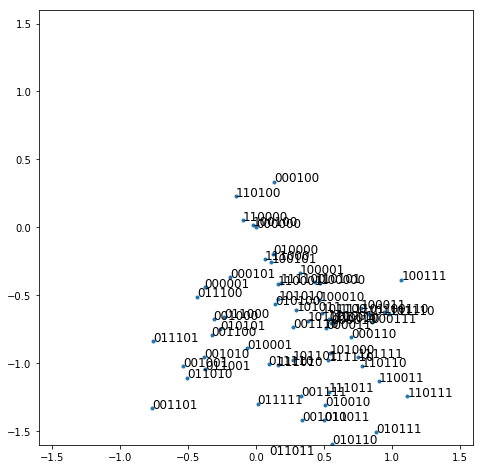

In [20]:
# constellation before training
[constellation,constellation_bits] = sess.run([enc_seed_norm,X_seed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'.')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0], constellation[ii,1], bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [21]:
bestLoss = 100000
bestAcc = 0
lastImprovement = 0
epoche = 0
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
batchSizeMultiples = 1
batchSize = batchSizeMultiples * trainingParam.batchSize

np_loss = []
np_ber  = []
np_gaussian_gmi  = []
np_sigmoid_gmi  = []

### Comment on the training procedure:
The training gets stuck early when a large batch size is chosen. For this reason we start with a low batch size, and iterativley increase it after temporary convergence. Training with a low batch size introduces a more stochastic gradient estimation, which helps to get out of the local minima.

In [22]:
print( 'START TRAINING ... ', flush=True )
while(True):
    epoche = epoche + 1

    sess.run(reset_ops)
    
    # train AE with iteratively increasing batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(batchSize,chParam.M)}
        sess.run(d_sigmoid_loss, feed_dict=feedDict)

    # gather performance metrics with large batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(trainingParam.sampleSize,chParam.M)}
        sess.run(update_ops, feed_dict=feedDict)

    [outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run([avg_loss, avg_ber, avg_gaussian_gmi, avg_sigmoid_gmi], feed_dict=feedDict)

    np_loss.append( outAvgLoss )
    np_ber.append( outAvgBer )
    np_gaussian_gmi.append( outAvgGaussianGmi )
    np_sigmoid_gmi.append( outAvgSigmoidGmi )
    
    if trainingParam.summaries:
        epocheSummaries = sess.run(epoche_summaries, feed_dict=feedDict)
        train_writer.add_summary(epocheSummaries,epoche)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    # convergence check and trainingState
    if epoche - lastImprovement > trainingParam.earlyStopping:

        saver.restore(sess=sess,save_path=checkpoint_path)
        bestLoss = 10000
        lastImprovement = epoche
        
        batchSizeMultiples = batchSizeMultiples + 4
        batchSize = batchSizeMultiples * trainingParam.batchSize        
        if batchSizeMultiples >= 17:
            break;

        print("batchSize: {}, batchSizeMultiples: {}".format(batchSize,batchSizeMultiples))

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {:04d} - avgLoss: {:.2f} - avgBer: {:.2e} - avgGaussianGmi: {:.2f} - avgSigmoidGmi: {:.2f}'.format(epoche,outAvgLoss,outAvgBer,outAvgGaussianGmi,outAvgSigmoidGmi),flush=True)

START TRAINING ... 
epoche: 0025 - avgLoss: 0.18 - avgBer: 9.23e-02 - avgGaussianGmi: 4.97 - avgSigmoidGmi: 4.46
epoche: 0050 - avgLoss: 0.17 - avgBer: 8.32e-02 - avgGaussianGmi: 5.10 - avgSigmoidGmi: 4.53
epoche: 0075 - avgLoss: 0.13 - avgBer: 6.12e-02 - avgGaussianGmi: 5.18 - avgSigmoidGmi: 4.86
epoche: 0100 - avgLoss: 0.11 - avgBer: 4.63e-02 - avgGaussianGmi: 5.30 - avgSigmoidGmi: 5.07
epoche: 0125 - avgLoss: 0.11 - avgBer: 4.50e-02 - avgGaussianGmi: 5.33 - avgSigmoidGmi: 5.04
epoche: 0150 - avgLoss: 0.11 - avgBer: 4.30e-02 - avgGaussianGmi: 5.35 - avgSigmoidGmi: 5.08
epoche: 0175 - avgLoss: 0.10 - avgBer: 3.75e-02 - avgGaussianGmi: 5.35 - avgSigmoidGmi: 5.18
INFO:tensorflow:Restoring parameters from results_GMI_NLIN/checkpoint/M064_PdBm-2.00_seed1338/best
batchSize: 320, batchSizeMultiples: 5
epoche: 0200 - avgLoss: 0.08 - avgBer: 3.17e-02 - avgGaussianGmi: 5.37 - avgSigmoidGmi: 5.29
epoche: 0225 - avgLoss: 0.08 - avgBer: 3.09e-02 - avgGaussianGmi: 5.39 - avgSigmoidGmi: 5.33
INFO:t

INFO:tensorflow:Restoring parameters from results_GMI_NLIN/checkpoint/M064_PdBm-2.00_seed1338/best


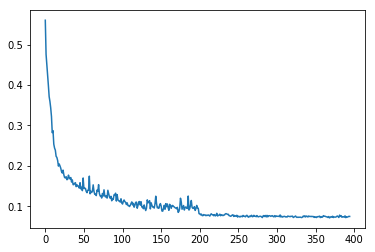

In [23]:
saver.restore(sess=sess,save_path=checkpoint_path)
np_loss = np.array( np_loss )
np_ber  = np.array( np_ber )
np_gaussian_gmi  = np.array( np_gaussian_gmi )
np_sigmoid_gmi  = np.array( np_sigmoid_gmi )
plt.plot( np_loss )

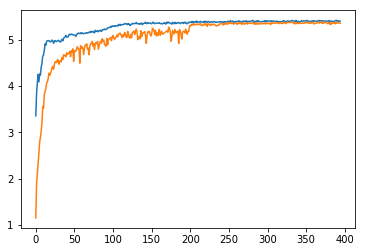

In [24]:
plt.plot( np_gaussian_gmi )
plt.plot( np_sigmoid_gmi )

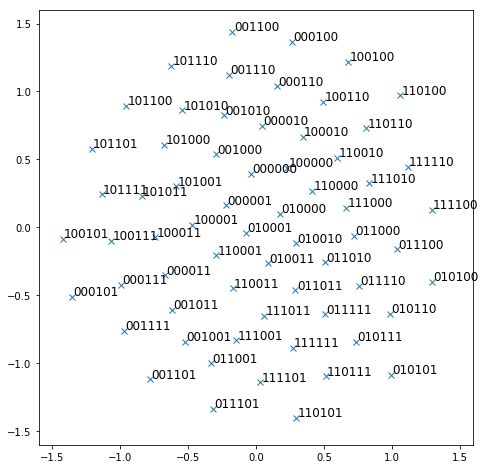

In [25]:
# constellation after training
[constellation,constellation_bits] = sess.run([enc_seed_norm,X_seed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'x')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0]+0.01, constellation[ii,1]+0.01, bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [26]:
sess.run(reset_ops)
for batch in range(0,100):
    feedDict = {X: cu.generateBitVectors(1000,chParam.M)}
    sess.run(update_ops, feed_dict=feedDict)
[outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run([avg_loss, avg_ber, avg_gaussian_gmi, avg_sigmoid_gmi], feed_dict=feedDict)
finalMetrics = { 'GaussianGMI': outAvgGaussianGmi, 'SigmoidGMI': outAvgSigmoidGmi, 'BER': outAvgBer, 'xentropy': outAvgLoss }

print( 'finalMetrics:', finalMetrics )

finalMetrics: {'GaussianGMI': 5.39913, 'SigmoidGMI': 5.3693233, 'BER': 0.028551662, 'xentropy': 0.07285876}
